<a href="https://colab.research.google.com/github/Makhmoor-fiza/Colab-Notebooks/blob/main/ResNet18_Medical_Image_Classification_Nails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -o -q /content/drive/MyDrive/Datasets.zip -d /content/Datasets

Verify the data structure

In [5]:
import os
print("Dataset structure:")
for root, dirs, files in os.walk('/content/Datasets/dataset'):
    level = root.replace('/content/Datasets/dataset', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    for d in dirs:
        print(f"{indent}    {d}/")

Dataset structure:
dataset/
    test/
    train/
    test/
        normal/
        melanoma/
        normal/
        melanoma/
    train/
        normal/
        melanoma/
        normal/
        melanoma/


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([  # Using 'val' as a validation set; rename to 'test' if preferred
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [8]:
data_dir = '/content/Datasets/dataset'  # Adjusted to match unzipped path


In [13]:
# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])  # Use 'val' key for transformations, as it's defined in data_transforms
}

# Create dataloaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(f"Dataset sizes: {dataset_sizes}")

class_names = image_datasets['train'].classes
print(f"Class names: {class_names}")  # Should output ['melanoma', 'normal']

Dataset sizes: {'train': 131, 'val': 58}
Class names: ['melanoma', 'normal']


In [14]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


In [15]:
# Freeze all layers except the final classification layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Modify the final layer to match the number of classes (2 in this case)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Output layer for 2 classes

# Ensure the final layer parameters are trainable
for param in model.fc.parameters():
    param.requires_grad = True

In [16]:
criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


In [17]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

Using device: cpu


In [26]:
import time
import matplotlib.pyplot as plt

num_epochs = 10

# Initialize lists to store losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + Optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Record metrics
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1} completed in {epoch_time:.2f} seconds\n')

print("Training complete!")

Epoch 1/10
----------
Train Loss: 0.1822 Acc: 0.9389
Val Loss: 0.3786 Acc: 0.8103
Epoch 1 completed in 47.73 seconds

Epoch 2/10
----------
Train Loss: 0.1775 Acc: 0.9389
Val Loss: 0.3688 Acc: 0.8103
Epoch 2 completed in 44.39 seconds

Epoch 3/10
----------
Train Loss: 0.1686 Acc: 0.9313
Val Loss: 0.3683 Acc: 0.8103
Epoch 3 completed in 46.20 seconds

Epoch 4/10
----------
Train Loss: 0.1906 Acc: 0.9313
Val Loss: 0.3515 Acc: 0.8103
Epoch 4 completed in 50.74 seconds

Epoch 5/10
----------
Train Loss: 0.1866 Acc: 0.9313
Val Loss: 0.3465 Acc: 0.8103
Epoch 5 completed in 45.78 seconds

Epoch 6/10
----------
Train Loss: 0.1963 Acc: 0.9389
Val Loss: 0.3871 Acc: 0.7931
Epoch 6 completed in 51.00 seconds

Epoch 7/10
----------
Train Loss: 0.1852 Acc: 0.9389
Val Loss: 0.3989 Acc: 0.7759
Epoch 7 completed in 46.14 seconds

Epoch 8/10
----------
Train Loss: 0.2091 Acc: 0.9389
Val Loss: 0.4202 Acc: 0.7759
Epoch 8 completed in 45.75 seconds

Epoch 9/10
----------
Train Loss: 0.1746 Acc: 0.9313
Val

Plotting the Graphs

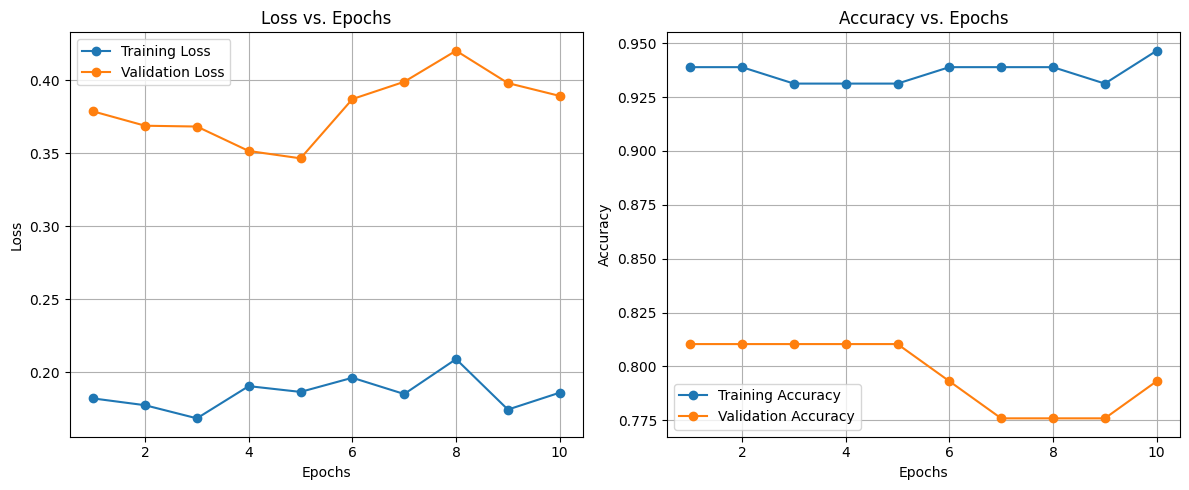

In [27]:
# Plotting Loss and Accuracy

# Set up the plot
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + Optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print()

print("Training complete!")


Epoch 1/10
----------
Train Loss: 0.6684 Acc: 0.5649
Val Loss: 0.5916 Acc: 0.6897

Epoch 2/10
----------
Train Loss: 0.5895 Acc: 0.6947
Val Loss: 0.5048 Acc: 0.7414

Epoch 3/10
----------
Train Loss: 0.4776 Acc: 0.7863
Val Loss: 0.4222 Acc: 0.7931

Epoch 4/10
----------
Train Loss: 0.4154 Acc: 0.8550
Val Loss: 0.3855 Acc: 0.7931

Epoch 5/10
----------
Train Loss: 0.3302 Acc: 0.8550
Val Loss: 0.4188 Acc: 0.7759

Epoch 6/10
----------
Train Loss: 0.2800 Acc: 0.8855
Val Loss: 0.3386 Acc: 0.8448

Epoch 7/10
----------
Train Loss: 0.2133 Acc: 0.9771
Val Loss: 0.3245 Acc: 0.8621

Epoch 8/10
----------
Train Loss: 0.2118 Acc: 0.9695
Val Loss: 0.3239 Acc: 0.8448

Epoch 9/10
----------
Train Loss: 0.2028 Acc: 0.9313
Val Loss: 0.3020 Acc: 0.8793

Epoch 10/10
----------
Train Loss: 0.1935 Acc: 0.9313
Val Loss: 0.3602 Acc: 0.8103

Training complete!


In [28]:
torch.save(model.state_dict(), '/content/drive/MyDrive/resnet18_classification_model.pth')
print("Model saved to Google Drive.")

Model saved to Google Drive.


In [29]:
# Function to load the model
def load_model(model_path, num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    # Change the model path to the correct file name.
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model
# Load the saved model
# This should match the file name used during saving in ipython-input-19-2402abca7815.
model_path = '/content/drive/MyDrive/resnet18_classification_model.pth'
model = load_model(model_path, num_classes=2)

<ipython-input-29-201dc2f99511>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


The predicted class is: melanoma


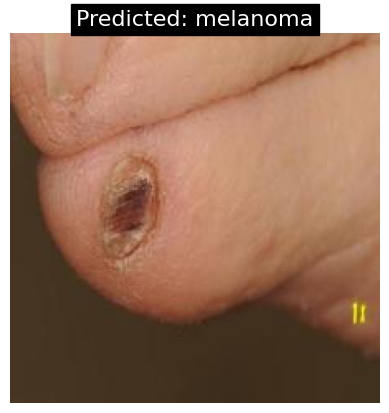

In [30]:
# Function to predict the class of an image
def predict_image(image_path, model, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0).to(device)  # Create a mini-batch as expected by the model

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)
    predicted_class_name = class_names[predicted_class.item()]

    return image, predicted_class_name

# Example usage:
# Replace 'test_image.jpg' with the path to your unseen image.
# If the image is in Google Drive, ensure to provide the correct path.
test_image_path = '/content/test_image1.jpg'  # Update this path

# Check if the test image exists
if os.path.exists(test_image_path):
    image, predicted_class_name = predict_image(test_image_path, model, class_names)
    print(f'The predicted class is: {predicted_class_name}')

    # Display the image with the predicted class name
    image_np = np.array(image)
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class_name}', fontsize=16, color='white', backgroundcolor='black')
    plt.show()
else:
    print(f"Test image not found at {test_image_path}. Please upload an image to the specified path.")
